In [74]:
# Privacy imports
from diffprivlib.mechanisms import exponential
from diffprivlib.mechanisms import laplace as diffpriv_laplace
from mechanisms import *


# Tooling imports
import numpy as np 
import pandas as pd
import argparse
import math
np.seterr(divide='ignore', invalid='ignore')
from scipy import optimize 
from scipy.interpolate import make_interp_spline, BSpline
import scipy.integrate as integrate
from scipy.stats import laplace
from scipy.integrate import quad
import scipy.special as special
from scipy.special import logsumexp
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
import statistics
import csv
import pickle

# For plotting colors imports
from matplotlib.pyplot import cm

In [75]:
def reset_color_iterator():

    return iter(["cyan", "magenta", "red", "orange", "green", "blue", "indigo", "darkgray", "dimgray", "black"])
color = reset_color_iterator()

# Error Analysis 

## Worst case scenario

### Helper functions

In [76]:
def plotting_error_analysis(epsilon, sensitivity, worst_case_probabilities, expected_errors_dict, expected_error_ratios_em_err, expected_error_ratios_pf_err, num_categories, num_categories_list, p_values, p_index, num_true_categories):
    r"""
    Plots the anylsis of the error of permute-and-flip, the exponential mechanism and enhanced randomized response
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probabilities : list
        The probability values that yield the worst expected error for a given number of categories
        
    expected_errors_dict : dictionary of lists
        Worst-case expected errors for each of the mechanisms
        
    expected_error_ratios_em_err: dictionary of lists
        Ratios between the expected errors of the exponential mechanism and enhanced randomized response.
        
    expected_error_ratios_pf_err: dictionary of lists
        Ratios between the expected errors of the permute-and-flip mechanism and enhanced randomized response.
    
    num_categories_list: list of ints
        Heads probability in randomized response
        
    p_values: list of floats
        List of heads probabilities of randomized response
        
    p_index: it
        Index to select a particular element in p_values for experimentation
        
    num_true_categories: int
        Number of categories that are in the bounding interval
        
    num_true_categories_list: list, optional
        List of the number of categories that are in the bounding interval
        
    case: int, optional
        It is eaither best or worst case scneario within the worst case scenario
    """  
    
    x = worst_case_probabilities
    
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(18.5, 10.5)

    
    # First we plot the expected errors
    for key, expected_errors in expected_errors_dict.items():
        
        # We will compare ERR with EM in one plot, so we need to skip PF
        if key == r'$\mathcal{M}_{PF}$':
            continue

        axs[0, 0].plot(x, expected_errors, label=key)
        axs[0, 0].set_title('(n={}, \u03B5={}, \u0394={})'.format(num_categories, epsilon, sensitivity), fontsize=23)

    axs[0, 0].legend(fontsize=20)
    #axs[0, 0].set_ylim(bottom=0, top=2.3)
        
    
    axs[0, 0].set(xlabel='p\'', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')
    
    for key, expected_errors in expected_errors_dict.items():
        
        # We will compare ERR with PF in one plot, so we need to skip PF
        if key == r'$\mathcal{M}_{EM}$':
            continue

        axs[0, 1].plot(x, expected_errors, label=key)
        axs[0, 1].set_title('(n={}, \u03B5={}, \u0394={})'.format(num_categories, epsilon, sensitivity), fontsize=23)
    
    axs[0, 1].legend(fontsize=20)
    #axs[0, 1].set_ylim(bottom=0, top=2.3)
    
    axs[0, 1].set(xlabel='p\'', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')
    
    # Now we plot the ratios
    for key, ratios in expected_error_ratios_em_err.items():

        axs[1, 0].plot(x, ratios, label=key)
        axs[1, 0].set_title('(p={}, \u03B5={}, \u0394={})'.format(p_values[p_index], epsilon, sensitivity), fontsize=23)#, num_true_categories))        

    axs[1, 0].legend(ncol=2, fontsize=20)
    #axs[1, 0].set_ylim(bottom=1, top=2.1)

    axs[1, 0].set(xlabel='p\'', ylabel=r'$\dfrac{𝔼[Ɛ(\mathcal{M}_{EM}, \vec{q})]}{𝔼[Ɛ(\mathcal{M}_{ERR}, \vec{q})]}$')

    for key, ratios in expected_error_ratios_pf_err.items():

        axs[1, 1].plot(x, ratios, label=key)
        #axs[1, 1].plot(x, [1]*len(x), '--', color='black')
        axs[1, 1].set_title('(p={}, \u03B5={}, \u0394={})'.format(p_values[p_index], epsilon, sensitivity), fontsize=23)#, num_true_categories))        
         
    axs[1, 1].legend(ncol=2, fontsize=20)
    #axs[1, 1].set_ylim(bottom=1, top=2.1)

    axs[1, 1].set(xlabel='p\'', ylabel=r'$\dfrac{𝔼[Ɛ(\mathcal{M}_{PF}, \vec{q})]}{𝔼[Ɛ(\mathcal{M}_{ERR}, \vec{q})]}$')
    
    # labels fontsize
    axs[0, 0].xaxis.get_label().set_fontsize(25)
    axs[0, 0].yaxis.get_label().set_fontsize(25)
    axs[0, 1].xaxis.get_label().set_fontsize(25)
    axs[0, 1].yaxis.get_label().set_fontsize(25)
    axs[1, 0].xaxis.get_label().set_fontsize(25)
    axs[1, 0].yaxis.get_label().set_fontsize(25)
    axs[1, 1].xaxis.get_label().set_fontsize(25)
    axs[1, 1].yaxis.get_label().set_fontsize(25)
    # ticks
    axs[0, 0].tick_params(axis='x', labelsize=23)
    axs[0, 0].tick_params(axis='y', labelsize=23)
    axs[0, 1].tick_params(axis='x', labelsize=23)
    axs[0, 1].tick_params(axis='y', labelsize=23)
    axs[1, 0].tick_params(axis='x', labelsize=23)
    axs[1, 0].tick_params(axis='y', labelsize=23)
    axs[1, 1].tick_params(axis='x', labelsize=23)
    axs[1, 1].tick_params(axis='y', labelsize=23)
    
    plt.subplots_adjust(wspace=0.25, hspace=0.4)
    # Best case
    if num_categories < 1000:
        if epsilon >= 1:
            plt.savefig("Figures/zz_EM_PF_Worst_Case_Expected_error_analysis_small_n.pdf", bbox_inches='tight')
        else: 
            plt.savefig("Figures/zz_EM_PF_Worst_Case_Expected_error_analysis_small_n_low_epsn.pdf", bbox_inches='tight')
    else:
        if epsilon >= 1:
            plt.savefig("Figures/zz_EM_PF_Worst_Case_Expected_error_analysis_large_n.pdf", bbox_inches='tight')
        else: 
            plt.savefig("Figures/zz_EM_PF_Worst_Case_Expected_error_analysis_large_n_low_epsn.pdf", bbox_inches='tight')
    plt.show()

In [77]:
def worst_case_expected_error_exponential_mechanism(epsilon, sensitivity, worst_case_probability, num_categories, p=0, num_true_categories=1):
    r"""
    It is interesting to learn the values of the expected error in a context (quality vector) that yields
    the worst mechanism utility. In this, setting, comparisons between algorithms can bring new insights.
    
    This function implements Equation 7 of the publication found: https://arxiv.org/abs/2010.12603
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probability : float
        The probability value generated with the worst-case utility vector

    num_categories : int
        Number of unique categories
    
    p: float, optional
        Heads probability in randomized response
        
    num_true_categories: int, optional
        Number of categories that are in the bounding interval    
    """  
    
    return (2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
    
def worst_case_expected_error_permute_and_flip(epsilon, sensitivity, worst_case_probability, num_categories, p=0, num_true_categories=1):
    r"""
    It is interesting to learn the values of the expected error in a context (quality vector) that yields
    the worst mechanism utility. In this, setting, comparisons between algorithms can bring new insights.
    
    This function implements Equation 8 of the publication found: https://arxiv.org/abs/2010.12603
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probability : float
        The probability value generated with the worst-case utility vector

    num_categories : int
        Number of unique categories
    
    p: float, optional
        Heads probability in randomized response
    
    num_true_categories: int, optional
        Number of categories that are in the bounding interval
    """  
    return (2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - (1-(1-worst_case_probability)**(num_categories))/(worst_case_probability*num_categories))
    
def worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, num_categories, p, num_true_categories=1):
    r"""
    It is interesting to learn the values of the expected error in a context (quality vector) that yields
    the worst mechanism utility. In this, setting, comparisons between algorithms can bring new insights.
    
    It is a modification of equation 7 of the publication found:  https://arxiv.org/abs/2010.12603, so that
    it adapts to enhanced randomized response.
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probability : float
        The probability value generated with the worst-case utility vector

    num_categories : int
        Number of unique categories
    
    p: float
        Heads probability in randomized response
        
    num_true_categories: int
        Number of categories that are in the bounding interval
    """  

    a = (1-p)*(2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
    b = (2 * sensitivity / epsilon) * (p/num_true_categories) * (num_true_categories - 1) * np.log(1/worst_case_probability)
    return a + b 

In [78]:
def executing_analysis(epsilon, sensitivity, num_categories, worst_case_probabilities, p_values, p_index, num_categories_list, num_true_categories=1):
    r"""
    Main functions that triggers the execution of the anaylsis of the different mechaisms and plotting.
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    num_categories : int
        Number of unique categories
        
    worst_case_probabilities : list of floats
        The probability values generated with the worst-case utility vector
    
    p_values: list of floats
        List of heads probabilities of randomized response
        
    p_index: it
        Index to select a particular element in p_values for experimentation
        
    num_categories_list: list of ints
        Heads probability in randomized response
        
    num_true_categories: int
        Number of categories that are in the bounding interval
        
    num_true_categories_list: list, optional
        List of the number of categories that are in the bounding interval
        
    case: int, optional
        It is eaither best or worst case scneario within the worst case scenario
    """    
    # EXPECTED ERROR
    expected_errors_dict = defaultdict(list)
    expected_error_ratios_em_err = defaultdict(list)
    expected_error_ratios_pf_err = defaultdict(list)
    
    # We calculate the expected error for each possible worst-case probability value (which come from
    # the quality vectors that yield the worst expected error)
    for worst_case_probability in worst_case_probabilities:
        
        expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(worst_case_expected_error_exponential_mechanism(epsilon, sensitivity, worst_case_probability, num_categories))
        expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(worst_case_expected_error_permute_and_flip(epsilon, sensitivity, worst_case_probability, num_categories))
        
        c = np.log(worst_case_probability) * 2 * sensitivity / epsilon
        if abs(c) <= 2*sensitivity:
            num_true_categories = num_categories
        else:
            num_true_categories = 1
        
        for p in p_values:
            key_name = r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)
            expected_errors_dict[key_name].append(worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, num_categories, p, num_true_categories))
    
    # RATIOS OF EXPECTED ERROR
    for n in num_categories_list:

        temp_list_expected_errors_EM = []
        temp_list_expected_errors_PF = []
        temp_list_expected_errors_ERR = []
        
        for worst_case_probability in worst_case_probabilities:
            
            c = np.log(worst_case_probability) * 2 * sensitivity / epsilon
            if abs(c) <= sensitivity:
                num_true_categories = num_categories
            else:
                num_true_categories = 1
            
            temp_list_expected_errors_EM.append(worst_case_expected_error_exponential_mechanism(epsilon, sensitivity, worst_case_probability, n))
            temp_list_expected_errors_PF.append(worst_case_expected_error_permute_and_flip(epsilon, sensitivity, worst_case_probability, n))
            temp_list_expected_errors_ERR.append(worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, n, p_values[p_index], num_true_categories))
        
        expected_error_ratios_em_err['n={}'.format(n)] = [em / err for em, err in zip(temp_list_expected_errors_EM, temp_list_expected_errors_ERR)]
        #expected_error_ratios_em_err['EM/ERR (n={})'.format(n)] = [em / err for em, err in zip(temp_list_expected_errors_EM, temp_list_expected_errors_PF)]

        expected_error_ratios_pf_err['n={}'.format(n)] = [pf / err for pf, err in zip(temp_list_expected_errors_PF, temp_list_expected_errors_ERR)]
    
    plotting_error_analysis(epsilon, sensitivity, worst_case_probabilities, expected_errors_dict, expected_error_ratios_em_err, expected_error_ratios_pf_err, num_categories, num_categories_list, p_values, p_index, num_true_categories)
    

## Error analysis execution

### Expected error - Only one category in the bounding interval

In [66]:
# Independent variables
_epsilon = 0.1
_sensitivity = 1
_num_categories = 5
_num_categories_list = [2, 3, 5, 10]

_worst_case_probabilities = np.arange(1, 101, 1)/100
_p_values = [0.25, 0.5, 0.75]
_p_index = 2

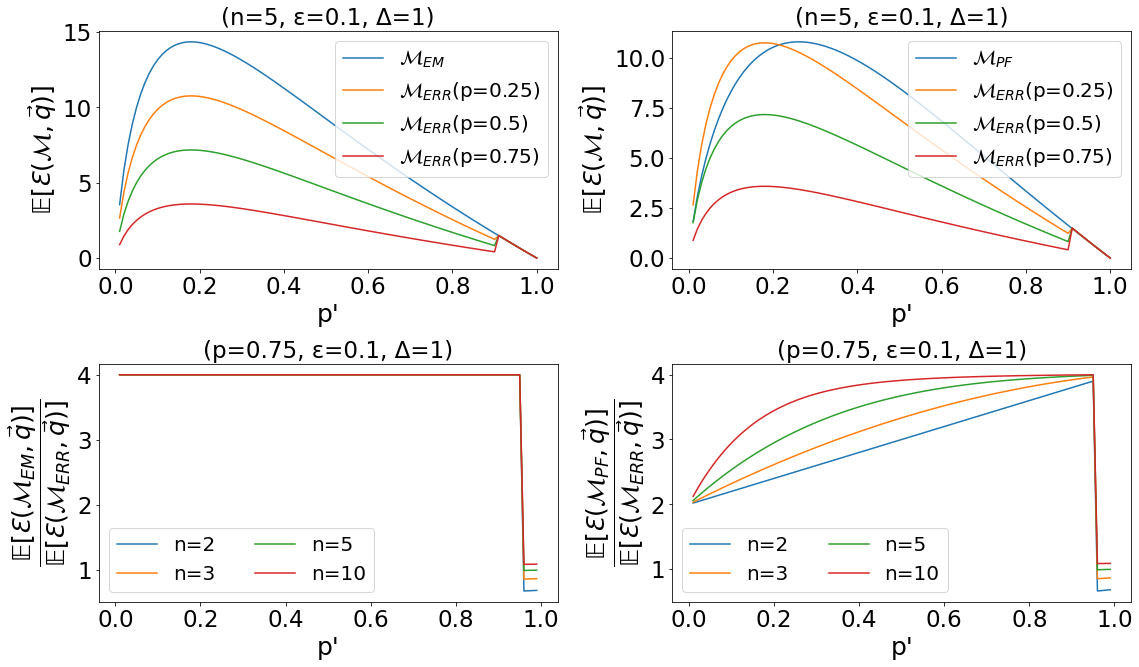

In [67]:
executing_analysis(_epsilon, _sensitivity, _num_categories, _worst_case_probabilities, _p_values, _p_index, _num_categories_list)

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

# The ratio in. the exponential mechanism = 1/(1-p). Which is the max ratio value in comparison to the exponential mechanism
# And it starts half way. Thus, with p=0.5, the entirity of the range ERR is better

### Large number of categories

In [42]:
# Independent variables
_epsilon = 1
_sensitivity = 1
_num_categories = 10000

_num_categories_list = [2000, 3000, 5000, 10000, 50000] 
_worst_case_probabilities = np.arange(1, 101, 1)/100
_p_values = [0.25, 0.33, 0.5, 0.75, 0.95]
_p_index = 2

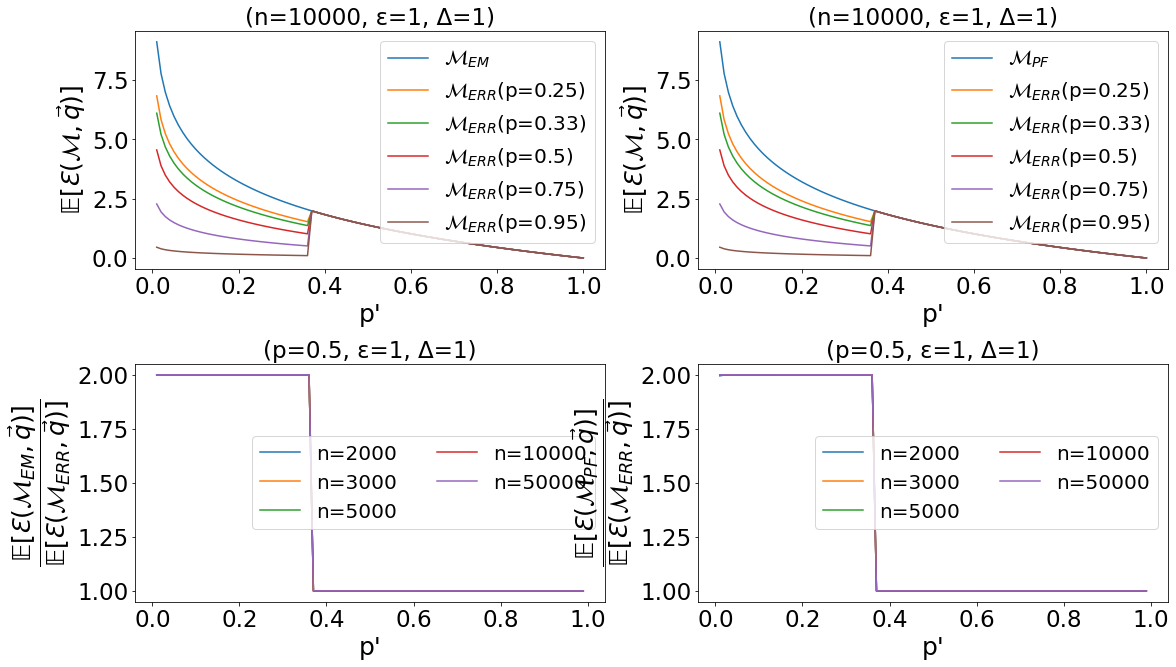

In [43]:
executing_analysis(_epsilon, _sensitivity, _num_categories, _worst_case_probabilities, _p_values, _p_index, _num_categories_list)

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX


#### Helper functions

In [79]:
def plotting_worst_case_error(epsilon, sensitivity, max_expected_errors_dict, max_num_categories):
    r"""
    Plots the results of the experiments about worst-case error.
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    max_num_categories: int
        The experiments will be carried out from having 2 to max_num_categories categories
        
    expected_error_calculation: function
        
        It can either be: worst_case_expected_error_exponential_mechanism, worst_case_expected_error_permute_and_flip, 
        worst_case_expected_error_enhanced_randomised_response
    
    num_categories : int
        Number of unique categories
        
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    p_values: list of floats
        List of heads probabilities of randomized response
        
    case: int, optional
        It is eaither best or worst case scneario within the worst case scenario
    """      
    n = np.arange(2, max_num_categories, 1)
    
    fig, axs = plt.subplots()
    
    for key, max_expected_errors in max_expected_errors_dict.items():
        
        c = next(color)
        if key == r'$\dfrac{Δ}{2ε}log(n)$' or key == r'$\dfrac{2Δ}{ε}log(n)$' or key == r'$\mathcal{M}_{ERR}$' + '(p={})'.format(1):
            
            axs.plot(n, max_expected_errors, '--', label=key, c=c)
            continue
            
        axs.plot(n, max_expected_errors, label=key)#, c=c)
    axs.set_title('(\u03B5={}, \u0394={})'.format(epsilon, sensitivity), fontsize='xx-large')
        
    axs.set(xlabel='n', ylabel='Worst-Case Expected Error')
    
    axs.xaxis.get_label().set_fontsize('xx-large')
    axs.yaxis.get_label().set_fontsize('xx-large')
    axs.tick_params(axis='x', labelsize='x-large')
    axs.tick_params(axis='y', labelsize='x-large')
    
    #plt.legend(loc=4, ncol=3, prop={'size': 10})
    #plt.legend(loc=(-0.15, -0.55), ncol=4) 
    plt.yscale('log')
    plt.xscale('log')
    
    if epsilon >= 1:
        plt.savefig("Figures/zz_Bounded_worst_case_expected_error_analysis.pdf", bbox_inches='tight')
    else:
        plt.savefig("Figures/zz_Bounded_worst_case_expected_error_analysis_low_eps.pdf", bbox_inches='tight')
    plt.show()
    

In [80]:
def function_for_maximizing_worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, num_categories, p):
    r"""
    It is interesting to learn the values of the expected error in a context (quality vector) that yields
    the worst mechanism utility. In this, setting, comparisons between algorithms can bring new insights.
    
    It is a modification of equation 7 of the publication found:  https://arxiv.org/abs/2010.12603, so that
    it adapts to enhanced randomized response.
    
    Parameters
    ----------
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.

    worst_case_probability : float
        The probability value generated with the worst-case utility vector

    num_categories : int
        Number of unique categories
    
    p: float
        Heads probability in randomized response
        
    num_true_categories: int
        Number of categories that are in the bounding interval
    """  
    c = np.log(worst_case_probability) * 2 * sensitivity / epsilon
    if abs(c) > 2*sensitivity:
        return (1-p)*(2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
    else:
        a = (1-p)*(2 * sensitivity / epsilon) * np.log(1/worst_case_probability) * (1 - 1/(1 + worst_case_probability*(num_categories-1)))
        b = (2 * sensitivity / epsilon) * (p/num_categories) * (num_categories - 1) * np.log(1/worst_case_probability)
        return a + b 

In [81]:
def maximize_expected_error_function(expected_error_calculation, num_categories, epsilon, sensitivity, p=0):    
    r"""
    Maximizes the probability (x-value) of the worst-case expected error function
    
    Parameters
    ----------
    expected_error_calculation: function
        
        It can either be: worst_case_expected_error_exponential_mechanism, worst_case_expected_error_permute_and_flip, 
        worst_case_expected_error_enhanced_randomised_response
    
    num_categories : int
        Number of unique categories
        
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    p: float, optional
        Heads probability in randomized response
    """            
    # We multiuply by -1 nso that we find the maximum and not the minimum
    worst_case_probability = -minimize_scalar(lambda worst_case_probability: -expected_error_calculation(epsilon, sensitivity, worst_case_probability, num_categories, p), bounds=(0,1), method='bounded').fun
    return worst_case_probability 


In [82]:
def worst_case_error_analysis(max_num_categories, epsilon, sensitivity, p_values):
    r"""
    Main fuction that executes the analysis of the worst-case error and plots the results
    
    Parameters
    ----------
    max_num_categories: int
        The experiments will be carried out from having 2 to max_num_categories categories
        
    expected_error_calculation: function
        
        It can either be: worst_case_expected_error_exponential_mechanism, worst_case_expected_error_permute_and_flip, 
        worst_case_expected_error_enhanced_randomised_response
    
    num_categories : int
        Number of unique categories
        
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    p_values: list of floats
        List of heads probabilities of randomized response
        
    case: int
        Takes values 1 or 2 depending on whether it is the best or the worst case
    """       
    max_expected_errors_dict = defaultdict(list)
    
    for n in range(2, max_num_categories):
        
        max_expected_errors_dict[r'$\dfrac{2Δ}{ε}log(n)$'].append((2*sensitivity)/epsilon*np.log(n))
        max_expected_errors_dict[r'$\dfrac{Δ}{2ε}log(n)$'].append((sensitivity)/(2*epsilon)*np.log(n))
        max_expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(maximize_expected_error_function(worst_case_expected_error_exponential_mechanism, n, epsilon, sensitivity))
        max_expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(maximize_expected_error_function(worst_case_expected_error_permute_and_flip, n, epsilon, sensitivity))
        
        for p in p_values:              
            max_expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(maximize_expected_error_function(function_for_maximizing_worst_case_expected_error_enhanced_randomised_response, n, epsilon, sensitivity, p))
            
    
    plotting_worst_case_error(epsilon, sensitivity, max_expected_errors_dict, max_num_categories)
    
    

## Execution

### Best case

In [83]:
# Independent variables
_epsilon = 1
_sensitivity = 1
_p_values = [0.25, 0.5, 0.75]

_max_num_categories = 10000
# For epsilon=1, bBefore 0.33=p, all have a jump - recommend p>1/3. This is due to the change of maximum in the 2-piece function, the maximum is different
# for higher ps, this happens later but because the error is 

In [63]:
color = reset_color_iterator()
worst_case_error_analysis(_max_num_categories, _epsilon, _sensitivity, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

KeyboardInterrupt: 

In [64]:
###### Independent variables
_epsilon = 0.1
_sensitivity = 1
_p_values = [0.25, 0.5, 0.75]

_max_num_categories = 100
# For epsilon=1, bBefore 0.33=p, all have a jump - recommend p>1/3. This is due to the change of maximum in the 2-piece function, the maximum is different
# for higher ps, this happens later but because the error is 

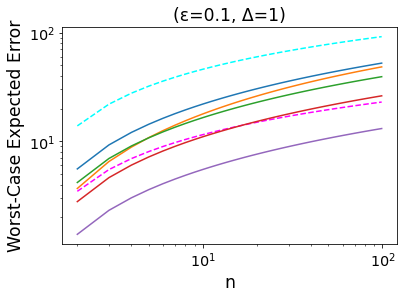

In [65]:
color = reset_color_iterator()
worst_case_error_analysis(_max_num_categories, _epsilon, _sensitivity, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

## Expected error

In [84]:
def plot_analytical_expected_error(sensitivity, epsilons, expected_errors_dict):
    r"""
    Plots the expected error of the different mechanisms applied to a quality vector
        
    Parameters
    ----------
    
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
    expected_errors_dict: dict
        Dictinary containing the expected errors to plot
    """
    x = epsilons
    
    fig, axs = plt.subplots()
    
    for key, expected_errors in expected_errors_dict.items():
                    
        axs.plot(x, expected_errors, label=key)
    
#     axs.set_title('(\u0394 = {})'.format(sensitivity))
    #axs.legend()
    axs.set(xlabel='\u03B5', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')
      
    plt.legend(loc=(0, -0.35), ncol=3) 
    plt.yscale('log')
    #plt.xscale('log')
    plt.savefig("Figures/zz_Analytical_expected_error.pdf", bbox_inches='tight')
    plt.show()
    
    

In [85]:
def em_expected_error(q, eps=1, sensitivity=1, monotonic=False):
    r"""
    Calculates the expected error of the exponential mechanism
    Adapted from: https://github.com/ryan112358/permute-and-flip
    
    Parameters
    ----------
   q : list
        list containing the quality values
    
    eps : float, optional
        Privacy parameter 

    sensitivity : float, optional
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
    monotonic: bool, optional
        Flags whether the utility functino is monotonic
    """        

    coef = 1.0 if monotonic else 0.5
    q_max = max(q)
    q = np.array(q)
    q = q - q_max
    logits = coef*eps/sensitivity*q
    pmf = np.exp(logits - logsumexp(logits))

    ans = q.max() - pmf @ q
    maxerr = q.max() - q.mean()
    if ans > maxerr or ans < 0:
        return maxerr
    return ans
    

In [86]:
def PF_pmf(q, eps=1, sensitivity=1, monotonic=False):
    r"""
    Calculates the pmf of the permute-and-flip mechanism.
    Adapted from: https://github.com/ryan112358/permute-and-flip
        
    Parameters
    ----------
    q : list
        list containing the quality values
    
    eps : float, optional
        Privacy parameter 

    sensitivity : float, optional
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
    monotonic: bool, optional
        Flags whether the utility functino is monotonic
    """    
    
    # q = np.array(list(candidate_qualities_dict.values()))
    coef = 1.0 if monotonic else 0.5
    q_max = max(q)
    q = np.array(q)
    p = np.exp(coef*eps/sensitivity*(q - q_max))
    n = q.size
    
    # first we will calculate 
    # sum(prod(p_i, i in S), |S| = k) for each k
    
    subsets = np.zeros(n)
    curr = np.cumsum(p)
    subsets[0] = curr[-1]
    for j in range(1,n):
        curr[j:] = np.cumsum(curr[j-1:-1]*p[j:])
        subsets[j] = curr[-1]   
    
    # coefficient vector: (-1)^k / (k+1) for k = 1..n
    coef = (np.arange(n) % 2 * 2 - 1) / (np.arange(n)+2)
    
    # we will now calculate
    # sum(prod(p_i, i in S), |S| = k, r not in S)
    # and compute the final probabilities
    
    ans = np.zeros(n)
    for i in range(n):
        new = np.copy(subsets)
        new[0] -= p[i]
        for j in range(1,n):
            new[j] -= new[j-1]*p[i]
        
        ans[i] = p[i] * (1 + new @ coef)
        
    return ans

In [87]:
def pf_expected_error(q, epsilon, sensitivity):
    r"""
    Calculates the expected error of the permute-and-flip mechanism.
    Adapted from: https://github.com/ryan112358/permute-and-flip
        
    Parameters
    ----------
    q : list
        list containing the quality values
    
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
    """        
    
    q_max = max(q)
    
    pf_pmf =  PF_pmf(q, epsilon, sensitivity)
     
    expected_error = q_max - sum([x*y for x,y in zip(q, pf_pmf)])
    
    return expected_error

In [88]:
def err_expected_error(q, eps=1,  p=0, sensitivity=1, monotonic=False):
    r"""
    Calculates the expected error of the enhanced randomized response mechanism
    Using the exponential mechanism code from: https://github.com/ryan112358/permute-and-flip    
    Parameters
    ----------
    q : list
        list containing the quality values
    
    eps : float, optional
        Privacy parameter 

    sensitivity : float, optional
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
    monotonic: bool, optional
        Flags whether the utility functino is monotonic
    """    
    q = sorted(q, reverse=True)
    q_max = max(q)
    q = np.array(q)
    coef = 1.0 if monotonic else 0.5
    q = q - q_max
    logits = coef*eps/sensitivity*q
    pmf = np.exp(logits - logsumexp(logits)) * (1-p)
            
    idx = 0
    while (q[idx] - q[idx+1]) <= sensitivity:
        #print(q[idx], q[idx])
        idx += 1
        if idx == len(q)-1:
            break
        continue

    number_categoris_equal_p = idx + 1
    
    temp_sum = 0
    for idx in range(number_categoris_equal_p):
        temp_sum += (p/number_categoris_equal_p) * q[idx]
    
    ans = q.max() - pmf @ q - temp_sum
    maxerr = q.max() - q.mean()
    if ans > maxerr or ans < 0:
        return maxerr
    return ans
    

In [89]:
def execute_analytical_expected_error_calculations(epsilons, p_values, sensitivity, candidate_qualities_dict):
    r"""
    Performs the experiments of the expected error
        
    Parameters
    ----------    
    epsilons: list of floats
        Privacy parameters
        
    p_values: list of float
        Contains the values p of the enhanced randomized response mechanism
        
    sensitivity : float, optional
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
   candidate_qualities_dict : dict
        dictionary containing the candidates pegged to their quality values
    """       
    expected_errors_dict = defaultdict(list)
       
    q = list(candidate_qualities_dict.values())
    q = np.array(q)
    for epsilon in epsilons:
        
        # Using existing code
        expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(expected_error(q, epsilon, em_pmf))
        expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(expected_error(q, epsilon, pf_pmf))
        
        # Using my code - yields the same results
        # expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(em_expected_error(q, epsilon, sensitivity))
        # expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(pf_expected_error(q, epsilon, sensitivity))
        
        for p in p_values:
            
            expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(err_expected_error(q, epsilon, p, sensitivity))
        
    plot_analytical_expected_error(sensitivity, epsilons, expected_errors_dict) 

## Synthetic data - Expected error

## Best case scenario

In [69]:
# independent variables
_epsilons = np.arange(0.01, 5, 0.01)
_p_values = [0.25, 0.3,  0.5, 0.75]
_sensitivity = 1
# Utility is decreasingly ordered 
_candidate_qualities_dict = {
    'A': 8,
    'B': 6,
    'C': 5,
    'D': 3,
    'E': 3,
    'F': 2,
    'G': 6,
    'H': 5,
    'I': 3,
    'J': 3,
    'K': 2
}


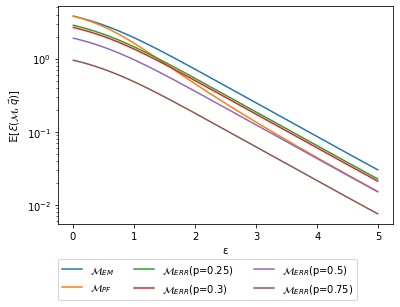

In [189]:
execute_analytical_expected_error_calculations(_epsilons, _p_values, _sensitivity, _candidate_qualities_dict)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

### Middle case scenario

In [190]:
_candidate_qualities_dict = {
    'A': 7,
    'B': 6,
    'C': 5,
    'D': 3,
    'E': 3,
    'F': 2
}

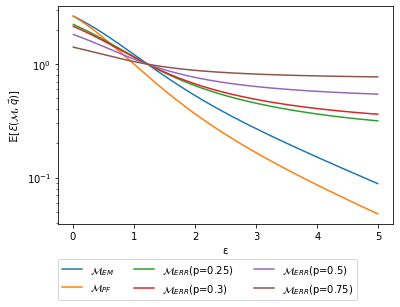

In [191]:
execute_analytical_expected_error_calculations(_epsilons, _p_values, _sensitivity, _candidate_qualities_dict)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

### Worst case scenario

In [192]:
_candidate_qualities_dict = {
    'A': 7,
    'B': 6,
    'C': 5,
    'D': 4,
    'E': 3,
    'F': 2
}

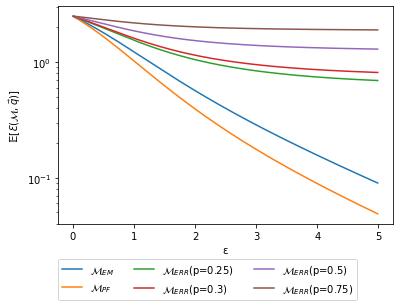

In [193]:
execute_analytical_expected_error_calculations(_epsilons, _p_values, _sensitivity, _candidate_qualities_dict)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

## Worst case scenario as a function of n

In [90]:
def plot_worst_case_error_analysys_over_n(sensitivity, epsilon, expected_errors_dict, max_num_categories):
    r"""
    Plots the expected error of the different mechanisms applied to a quality vector
        
    Parameters
    ----------
    
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
    expected_errors_dict: dict
        Dictinary containing the expected errors to plot
        
    max_num_categories:
        The maximum number of categories that is eperimented with
    """
    x = np.linspace(2, max_num_categories, max_num_categories-1)
    
    fig, axs = plt.subplots()
    
    for key, expected_errors in expected_errors_dict.items():
                    
        axs.plot(x, expected_errors, label=key)
    
    axs.set_title('(\u03B5={}, \u0394={})'.format(epsilon, sensitivity), fontsize='xx-large')
    #axs.legend()
    axs.set(xlabel='n', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')
    axs.xaxis.get_label().set_fontsize('xx-large')
    axs.yaxis.get_label().set_fontsize('xx-large')
    axs.tick_params(axis='x', labelsize='x-large')
    axs.tick_params(axis='y', labelsize='x-large')
    plt.legend(loc=2, ncol=1, fontsize='large') 
    plt.yscale('log')
    plt.xscale('log')
    if epsilon >= 1:
        plt.savefig("Figures/zz_Worst_case_Analytical_expected_error_large_eps.pdf", bbox_inches='tight')
    else:
        plt.savefig("Figures/zz_Worst_case_Analytical_expected_error_low_eps.pdf", bbox_inches='tight')

    plt.show()
    
    

In [91]:
def worst_case_error_analysys_over_n(max_num_categories, p_values, epsilon, sensitivity, quality_vectors_worst_case):
    r"""
    Performs the experiments of the expected error
        
    Parameters
    ----------    
    max_num_categories:
        The maximum number of categories that is eperimented with
        
    p_values: list of float
        Contains the values p of the enhanced randomized response mechanism

    epsilon: float
        Privacy parameters
        
    sensitivity : float, optional
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
   quality_vectors_worst_case : dict
        dictionary containing quality vectors in the worst case scenario for ERR across different number of categories
    """       
    expected_errors_dict = defaultdict(list)
    
    for n in range(2, max_num_categories+1):
        
        q = np.array(quality_vectors_worst_case[n])
        
        # Using existing functions
        expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(expected_error(q, epsilon, em_pmf))
        expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(expected_error(q, epsilon, pf_pmf))
        
        # Using my own functions
        # expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(em_expected_error(q, epsilon, sensitivity))
        # expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(pf_expected_error(q, epsilon, sensitivity))
        
        for p in p_values:
            
            expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(err_expected_error(q, epsilon, p, sensitivity))
    
    plot_worst_case_error_analysys_over_n(sensitivity, epsilon, expected_errors_dict, max_num_categories) 

In [92]:
# RUN ONCE
max_num_categories = 100000
quality_vectors_worst_case = defaultdict(list)
q_max = max_num_categories

for n in range(2, max_num_categories+1):
    counter = 0

    for _ in range(n):
        quality_vectors_worst_case[n].append(q_max - counter)
        counter += 1

with open('quality_vectors_worst_case.pkl', 'wb') as f:
    pickle.dump(quality_vectors_worst_case, f)

KeyboardInterrupt: 

In [ ]:
# RUN ONCE
with open('quality_vectors_worst_case.pkl', 'rb') as f:
    quality_vectors_worst_case = pickle.load(f)

In [ ]:
p_values = [0.25, 0.5, 0.75]
sensitivity = 1
epsilon = 1

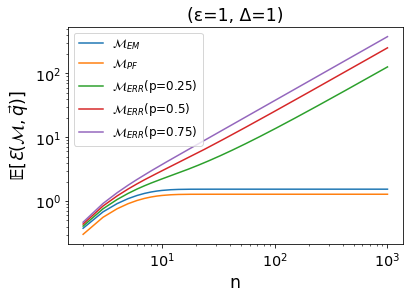

In [85]:
worst_case_error_analysys_over_n(max_num_categories, p_values, epsilon, sensitivity, quality_vectors_worst_case)

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [ ]:
epsilon = 0.1

In [ ]:
worst_case_error_analysys_over_n(max_num_categories, p_values, epsilon, sensitivity, quality_vectors_worst_case)

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

## Best case scenario as a function of n

In [107]:
def plot_best_case_error_analysys_over_n(sensitivity, epsilon, expected_errors_dict, max_num_categories):
    r"""
    Plots the expected error of the different mechanisms applied to a quality vector
        
    Parameters
    ----------
    
    epsilon : float
        Privacy parameter 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
    expected_errors_dict: dict
        Dictinary containing the expected errors to plot
        
    max_num_categories:
        The maximum number of categories that is eperimented with
    """
    x = np.linspace(2, max_num_categories, max_num_categories-1)
    
    fig, axs = plt.subplots()
    
    for key, expected_errors in expected_errors_dict.items():
                    
        axs.plot(x, expected_errors, label=key)
    
    axs.set_title('(\u03B5={}, \u0394={})'.format(epsilon, sensitivity),  fontsize='xx-large')
    #axs.legend()
    axs.set(xlabel='n', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')
    axs.xaxis.get_label().set_fontsize('xx-large')
    axs.yaxis.get_label().set_fontsize('xx-large')
    axs.tick_params(axis='x', labelsize='x-large')
    axs.tick_params(axis='y', labelsize='x-large')

    plt.legend(loc=4, ncol=2, fontsize='large') 
    plt.yscale('log')
    plt.xscale('log')
    if epsilon >= 1:
        plt.savefig("Figures/zz_Best_case_Analytical_expected_error_large_eps.pdf", bbox_inches='tight')
    else:
        plt.savefig("Figures/zz_Best_case_Analytical_expected_error_low_eps_rand.pdf", bbox_inches='tight')

    plt.show()
    
    

In [94]:
def best_case_error_analysys_over_n(max_num_categories, p_values, epsilon, sensitivity, quality_vectors_worst_case):
    r"""
    Performs the experiments of the expected error
        
    Parameters
    ----------    
    max_num_categories:
        The maximum number of categories that is eperimented with
        
    p_values: list of float
        Contains the values p of the enhanced randomized response mechanism

    epsilon: float
        Privacy parameters
        
    sensitivity : float, optional
        The sensitivity in utility values to a change in a datapoint in the underlying dataset
        
   quality_vectors_worst_case : dict
        dictionary containing quality vectors in the worst case scenario for ERR across different number of categories
    """       
    expected_errors_dict = defaultdict(list)
    
    for n in range(2, max_num_categories+1):
        
        q = np.array(quality_vectors_worst_case[n])
        
        # Using existing functions
        expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(expected_error(q, epsilon, em_pmf))
        expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(expected_error(q, epsilon, pf_pmf))
        
        # Using my own functions
        # expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(em_expected_error(q, epsilon, sensitivity))
        # expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(pf_expected_error(q, epsilon, sensitivity))
        
        for p in p_values:
            
            expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(err_expected_error(q, epsilon, p, sensitivity))
    
    plot_best_case_error_analysys_over_n(sensitivity, epsilon, expected_errors_dict, max_num_categories) 

In [95]:
# RUN ONCE
max_num_categories = 1000
quality_vectors_best_case = defaultdict(list)
q_max = max_num_categories

for n in range(2, max_num_categories+1):
    counter = 0

    for _ in range(n+1):
        quality_vectors_best_case[n].append(q_max - counter)
        if counter == 0:
            counter += 2
        else:
            counter += 1
        

with open('quality_vectors_best_case.pkl', 'wb') as f:
    pickle.dump(quality_vectors_best_case, f)

In [96]:
# RUN ONCE
with open('quality_vectors_best_case.pkl', 'rb') as f:
    quality_vectors_best_case = pickle.load(f)

In [97]:
p_values = [0.25, 0.5, 0.75]
sensitivity = 1
epsilon = 1

In [51]:
best_case_error_analysys_over_n(max_num_categories, p_values, epsilon, sensitivity, quality_vectors_best_case)

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

NameError: name 'err_expected_error' is not defined

In [98]:
epsilon = 0.1

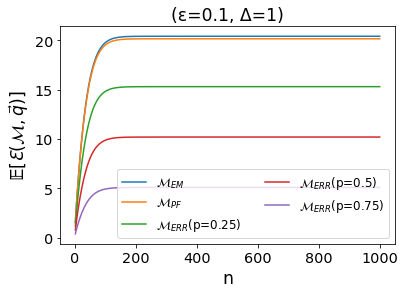

In [99]:
best_case_error_analysys_over_n(max_num_categories, p_values, epsilon, sensitivity, quality_vectors_best_case)

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [101]:
from random import seed
from random import random

In [102]:
# RUN ONCE
seed(3)
max_num_categories = 1000
quality_vectors_best_case_rand = defaultdict(list)
q_max = max_num_categories

for n in range(2, max_num_categories+1):
    
    quality_vectors_best_case_rand[n].append(max_num_categories)
    for _ in range(1, n+1):
        quality_vectors_best_case_rand[n].append(round(random()*(max_num_categories-2)))
                                                 
with open('quality_vectors_best_case_rand.pkl', 'wb') as f:
    pickle.dump(quality_vectors_best_case_rand, f)

In [103]:
# RUN ONCE
with open('quality_vectors_best_case_rand.pkl', 'rb') as f:
    quality_vectors_best_case_rand = pickle.load(f)

In [104]:
p_values = [0.25, 0.5, 0.75]
sensitivity = 1
epsilon = 1

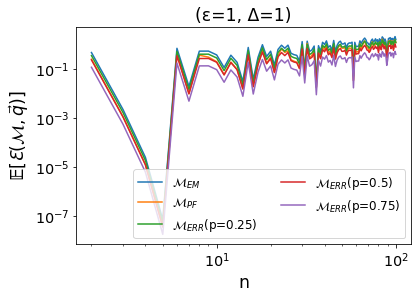

In [407]:
best_case_error_analysys_over_n(max_num_categories, p_values, epsilon, sensitivity, quality_vectors_best_case_rand)

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

In [105]:
epsilon = 0.1

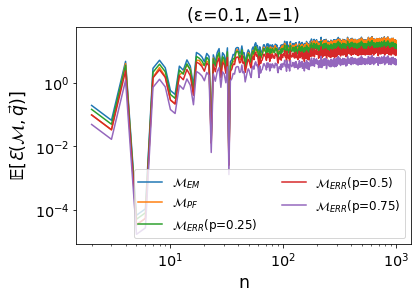

In [108]:
best_case_error_analysys_over_n(max_num_categories, p_values, epsilon, sensitivity, quality_vectors_best_case_rand)

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

## Datasets

In [38]:
def median_quality(x):
    A = np.cumsum(x)

    med = np.searchsorted(A, x.sum() / 2)

    N, n = x.sum(), x.size
    q = np.zeros(n)
    for i in range(0, med):
        q[i] = np.ceil(N - 2*A[i])
    q[med] = 0
    for i in range(med+1, n):
        q[i] = np.ceil(2*A[i-1] - N + 1)

    return -q

In [586]:
def get_lines(q):
    min_eps = 1e-4 #expected_epsilon(q, 1e3, pmf=em_pmf)
    max_eps = expected_epsilon(q, 1.0, pmf=em_pmf)
    epss = np.linspace(min_eps, max_eps, 100)
    q_max = max(q)
    err_025 = [err_expected_error(q, eps, p=0.25) for eps in epss]
    err_05 = [err_expected_error(q, eps, p=0.5) for eps in epss]
    err_075 = [err_expected_error(q, eps, p=0.75) for eps in epss]
    pf = [expected_error(q, eps, pf_pmf) for eps in epss]
    em = [expected_error(q, eps, em_pmf) for eps in epss]
    #due to numerical issues sometimes pf = maxerr (for near-zero epsilon)
    # this is a quick fix
    pf = np.minimum(pf, em)
    
    return epss, em, pf, err_025, err_05, err_075

def execute_real_data_experiments():
    r"""
    Adapted from: https://github.com/ryan112358/permute-and-flip
    Datasets from: https://github.com/dpcomp-org/dpcomp_core
    
    ...
    """
    args = lambda: None

    for dataset in ['HEPTH','MEDCOST','ADULTFRANK','SEARCHLOGS','PATENT']:
        for problem in ['median','mode']:
            args.dataset = dataset
            args.problem = problem
            args.domain = 1024

            x = np.load('data/%s.n4096.npy' % args.dataset).astype(np.float64)
            x = x.reshape(args.domain,-1).sum(axis=1)
            if args.problem == 'median':
                q = median_quality(x)
            elif args.problem == 'mode':
                q = 2*x # due to monotonicity of mode
            name = '%s-%s.pdf' % (args.dataset, args.problem)
            
            epss, em, pf, err_025, err_05, err_075 = get_lines(q)

            fig = plt.figure()
            plt.plot(epss, em, 'blue', linewidth=2, label='$\mathcal{M}_{EM}$')
            plt.plot(epss, pf, 'red', linewidth=2, label='$\mathcal{M}_{PF}$')
            plt.plot(epss, err_025, 'orange', linewidth=2, label='$\mathcal{M}_{ERR} (p=0.25)$')
            plt.plot(epss, err_05, 'green', linewidth=2, label='$\mathcal{M}_{ERR} (p=0.5)$')
            plt.plot(epss, err_075, 'cyan', linewidth=2, label='$\mathcal{M}_{ERR} (p=0.75)$')
            
            #plt.title('{}'.format(dataset), fontsize='x-large')
            plt.yscale('log')
            #plt.ylim(1,None)
            plt.xlabel('\u03B5', fontsize='large')
            plt.ylabel(r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$', fontsize='xx-large')
#             plt.xticks(fontsize='large')
#             plt.yticks(fontsize='large')
            #plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
            plt.legend(fontsize='large')
            #plt.tight_layout()
            plt.savefig("Figures/zz_{}_{}_Expected_Error.pdf".format(dataset, problem), bbox_inches='tight')
            print(name)
        

## Real data experiments - Expected error

HEPTH-median.pdf
HEPTH-mode.pdf
MEDCOST-median.pdf
MEDCOST-mode.pdf
ADULTFRANK-median.pdf
ADULTFRANK-mode.pdf
SEARCHLOGS-median.pdf
SEARCHLOGS-mode.pdf
PATENT-median.pdf
PATENT-mode.pdf


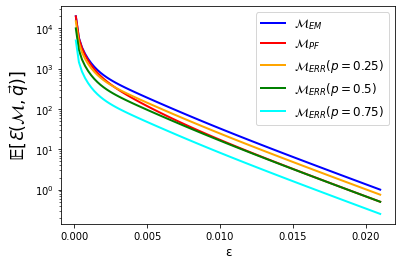

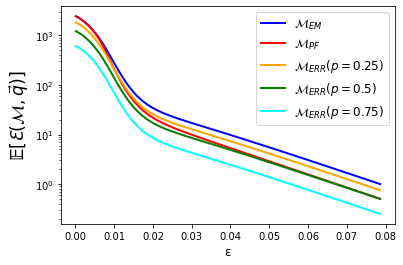

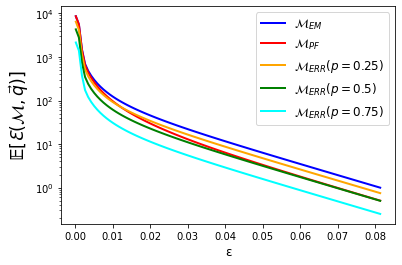

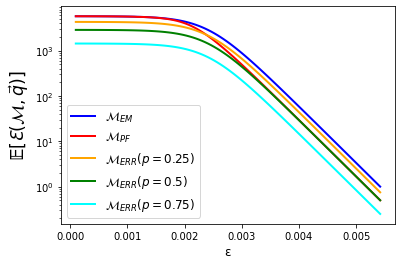

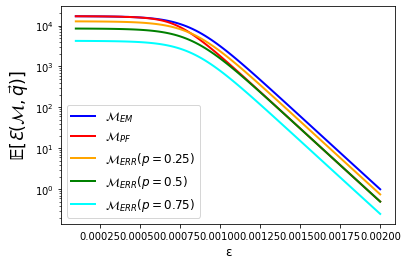

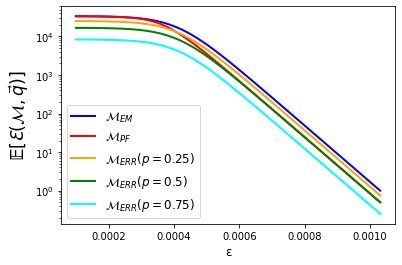

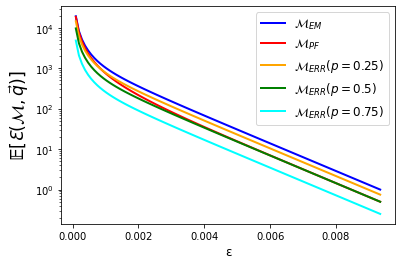

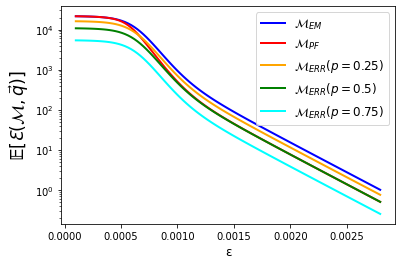

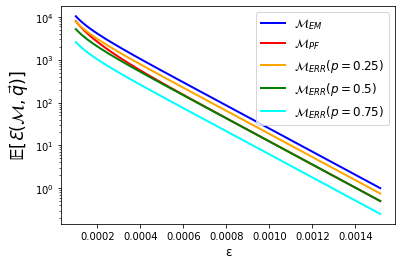

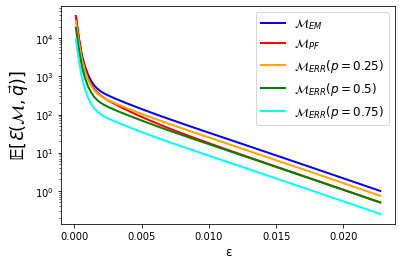

In [587]:
execute_real_data_experiments()

In [588]:
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX


## Bar plots - Real data - Expected value

#### Fetching the epsilons for a fixed expected error

In [350]:
def epsilon_binary_search(mechanism, q, target_error):
    
    eps_low = 0
    eps_high = 0.05
    eps_mid = 0
    wiggle = 0.9999
    _expected_error = 0    
    while eps_low <= eps_high:
        
        eps_mid = (eps_low + eps_high)/2
        
        if mechanism == 'pf':
            _expected_error = expected_error(q, eps_mid, pf_pmf)
        elif mechanism == 'em':
            _expected_error = expected_error(q, eps_mid, em_pmf)
        elif mechanism == 'err_025':
            _expected_error = err_expected_error(q, eps_mid, p=0.25)
        elif mechanism == 'err_05':
            _expected_error = err_expected_error(q, eps_mid, p=0.5)
        elif mechanism == 'err_075':
            _expected_error = err_expected_error(q, eps_mid, p=0.75)
        
        if _expected_error >= target_error*wiggle and _expected_error <= target_error/wiggle:
            return eps_mid
        
        # Monotonically decreasing 
        if _expected_error > target_error:
            eps_low = eps_mid
        else:
            eps_high = eps_mid
        

In [351]:
args = lambda: None

epss_datasets = {}
for dataset in ['HEPTH','ADULTFRANK', 'MEDCOST','SEARCHLOGS','PATENT']:
    
    
    epss = {}
    for problem in ['median','mode']:
        args.dataset = dataset
        args.problem = problem
        args.domain = 1024

        x = np.load('data/%s.n4096.npy' % args.dataset).astype(np.float64)
        x = x.reshape(args.domain,-1).sum(axis=1)
        if args.problem == 'median':
            q = median_quality(x)
        elif args.problem == 'mode':
            q = 2*x # due to monotonicity of mode

        target_error = 100
        
        eps_em = epsilon_binary_search('em', q, target_error)
        epss[problem] = eps_em
    epss_datasets[dataset] = epss
    
with open('epss_datasets.pkl', 'wb') as f:
    pickle.dump(epss_datasets, f)

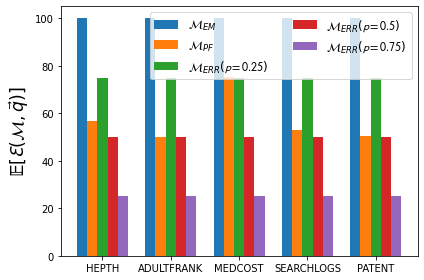

In [554]:
problem = 'median'
# problem = 'mode'

with open('epss_datasets.pkl', 'rb') as f:
    epss_datasets = pickle.load(f)
    
labels = ['HEPTH','ADULTFRANK', 'MEDCOST','SEARCHLOGS','PATENT']

pf_exp_err = []
em_exp_err = []
err_025_exp_err = []
err_05_exp_err = []
err_075_exp_err = []

for dataset in labels:
    
    args.dataset = dataset
    args.problem = problem
    args.domain = 1024

    x = np.load('data/%s.n4096.npy' % args.dataset).astype(np.float64)
    x = x.reshape(args.domain,-1).sum(axis=1)
    if args.problem == 'median':
        q = median_quality(x)
    elif args.problem == 'mode':
        q = 2*x # due to monotonicity of mode
    
    eps = epss_datasets[dataset][problem]
    
    pf_exp_err.append(expected_error(q, eps, pf_pmf))
    em_exp_err.append(expected_error(q, eps, em_pmf))
    err_025_exp_err.append(err_expected_error(q, eps, p=0.25))
    err_05_exp_err.append(err_expected_error(q, eps, p=0.5))
    err_075_exp_err.append(err_expected_error(q, eps, p=0.75))

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*2, em_exp_err, width, label=r'$\mathcal{M}_{EM}$')
rects2 = ax.bar(x - width, pf_exp_err, width, label=r'$\mathcal{M}_{PF}$')
rects3 = ax.bar(x, err_025_exp_err, width, label=r'$\mathcal{M}_{ERR} (\mathcal{p=0.25})$')
rects4 = ax.bar(x + width, err_05_exp_err, width, label=r'$\mathcal{M}_{ERR} (\mathcal{p=0.5})$')
rects5 = ax.bar(x + width*2, err_075_exp_err, width, label=r'$\mathcal{M}_{ERR} (\mathcal{p=0.75})$')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$', fontsize='xx-large')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize='medium')
plt.legend(ncol=2, loc=1, fontsize='large')
#plt.legend(loc=(0, -0.5), ncol=3) 


fig.tight_layout()
plt.savefig("Figures/zz_{}_Expected_error_bar_plot.pdf".format(problem), bbox_inches='tight')

plt.show()
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX


## Comparison with Report Noisy Max

### Helper functios

In [37]:
def plotting_expected_error_worst_case_quality_values_analysis(epsilon, sensitivity, num_categories, c_vector, expected_errors_dict):
    r"""
        Plots the experiments results
        
    Parameters
    ----------
    epsilon : float
        Privacy paramete

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
    
    num_categories: int
        Number of categories which share the same utility value (-1)
        
    c_vector: list of floats
        The values of the utility functions, which are the same for all categories.    
    
    expected_errors_dict: dictionary 
        Contains  the expected errors of each mechanism
    """       
    x = c_vector
    fig, axs = plt.subplots()
    for key, values in expected_errors_dict.items():
    
        axs.plot(x, values, label=key)
    
    axs.set_title('(\u03B5={}, n={})'.format(epsilon, num_categories), fontsize='xx-large')                   
    axs.set(xlabel=r'$v$', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')
    
    #plt.subplots_adjust(wspace=0.05)
    plt.legend(loc=2, ncol=1, fontsize='large')
    
    axs.xaxis.get_label().set_fontsize('xx-large')
    axs.yaxis.get_label().set_fontsize('xx-large')
    axs.tick_params(axis='x', labelsize='x-large')
    axs.tick_params(axis='y', labelsize='x-large')
    
    plt.xticks(list(np.arange(-20, 5, step=5)) + [-1])
    if epsilon >= 1:
        if num_categories < 10:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_low_num_categories.pdf", bbox_inches='tight')
        elif num_categories < 10000:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_mid_num_categories.pdf", bbox_inches='tight')
        else:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_large_num_categories.pdf", bbox_inches='tight')
    else:
        if num_categories < 10:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_low_num_categories_low_eps.pdf", bbox_inches='tight')
        elif num_categories < 10000:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_mid_num_categories_low_eps.pdf", bbox_inches='tight')
        else:
            plt.savefig("Figures/zz_Expected_errors_experiments_varying_c_large_num_categories_low_eps.pdf", bbox_inches='tight')
    plt.show()
    

In [38]:
def worst_case_expected_error_noisy_max(c, epsilon, n=2):
    r"""
        Executes the worst case expected error of noisy max
        
    Parameters
    ----------   
    c: float
        The value of the utility function, which are the same for all categories.
        
    n: int
        Number of categories which share the same utility value (-1)

    """       
    lap = laplace(loc=0, scale=2.0/epsilon) #Modified
    foo = lambda z: lap.pdf(z)*lap.cdf(z-c)**(n-1)
    star = quad(foo, a=-np.inf, b=np.inf)[0]
    return 0-(1-star)*c

In [39]:
def expected_error_worst_case_quality_values_analysis(epsilon, sensitivity, c_vector, num_categories, p_values):
    r"""
        Executes the experiments
        
    Parameters
    ----------
    epsilon : float
        Privacy paramete

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
    
    c_vector: list of floats
        The values of the utility functions, which are the same for all categories.
        
    num_categories: int
        Number of categories which share the same utility value (-1)
        
    p_values: list of floats
        List of heads probabilities of randomized response
    """      
    expected_errors_dict = defaultdict(list)
    
    # Initializing lists
    expected_errors_dict[r'$\mathcal{M}_{EM}$'] = []
    expected_errors_dict[r'$\mathcal{M}_{PF}$'] = []
#     expected_errors_dict[r'$\mathcal{M}_{NM}$'] = []
    for p in p_values:

        expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)] = []
    
    # Obtaining the analytical values
    for c in c_vector:
        
        worst_case_probability = np.exp(epsilon * c / 2 / sensitivity)
        
        expected_errors_dict[r'$\mathcal{M}_{EM}$'].append(worst_case_expected_error_exponential_mechanism(epsilon, sensitivity, worst_case_probability, num_categories))
        expected_errors_dict[r'$\mathcal{M}_{PF}$'].append(worst_case_expected_error_permute_and_flip(epsilon, sensitivity, worst_case_probability, num_categories))
#         expected_errors_dict[r'$\mathcal{M}_{NM}$'].append(worst_case_expected_error_noisy_max(c, epsilon, num_categories))
        
        if abs(c) <= sensitivity:
            num_true_categories = num_categories
        else:
            num_true_categories = 1
                
        for p in p_values: 
            
            expected_errors_dict[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(worst_case_expected_error_enhanced_randomised_response(epsilon, sensitivity, worst_case_probability, num_categories, p, num_true_categories))
    
    plotting_expected_error_worst_case_quality_values_analysis(epsilon, sensitivity, num_categories, c_vector, expected_errors_dict)


### Independent variables

In [40]:
_epsilon = 1
_sensitivity = 1
_num_categories = 3
_c_vector = np.arange(-20,0.25,0.25)
_p_values = [0.25, 0.5, 0.75]


### Experiments execution

### Worst case

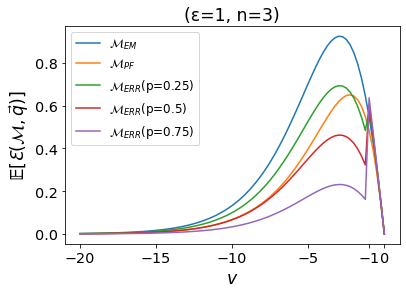

In [41]:
expected_error_worst_case_quality_values_analysis(_epsilon, _sensitivity, _c_vector, _num_categories, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

### Middle case

In [42]:
_num_categories = 10

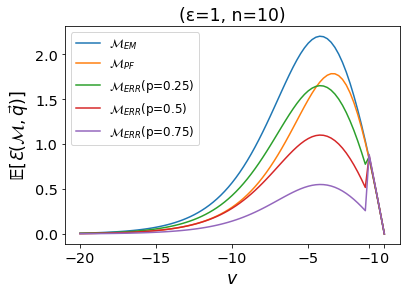

In [43]:
expected_error_worst_case_quality_values_analysis(_epsilon, _sensitivity, _c_vector, _num_categories, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX


## Better case

In [582]:
_num_categories = 10000

/usr/local/anaconda3/envs/privacy/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4067: RuntimeWarning: overflow encountered in exp
  return np.where(x > 0, 1.0-0.5*np.exp(-x), 0.5*np.exp(x))


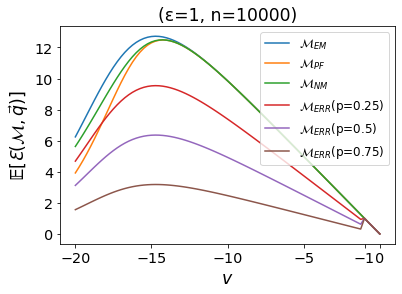

In [583]:
expected_error_worst_case_quality_values_analysis(_epsilon, _sensitivity, _c_vector, _num_categories, _p_values)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX


# Disclosure risk

In [6]:
def upper_bound_epsilon(num_neighbors, disclosure_risk):
    
    return np.log(disclosure_risk * (num_neighbors - 1) / (1 - disclosure_risk)) 

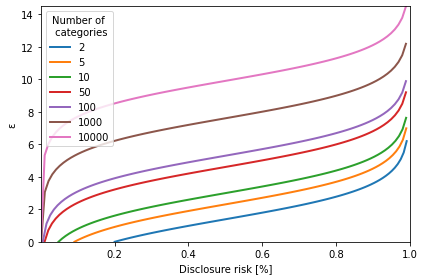

In [7]:
num_categories_list = [2, 5, 10, 50, 100, 1000, 10000]
fig = plt.figure()

for num_categories in num_categories_list:
    
    num_neighbors = 2 * num_categories + 1
    disclosure_risks = np.linspace(1/num_neighbors,1, 100)
    eps_upper_bounds = [upper_bound_epsilon(num_neighbors, disclosure_risk) for disclosure_risk in disclosure_risks]
    plt.plot(disclosure_risks, eps_upper_bounds, linewidth=2, label='{}'.format(num_categories))

plt.plot
plt.margins(x=0)
plt.margins(y=0)
# plt.yscale('log')
plt.xlim(None, 1)
plt.xlabel('Disclosure risk [%]')#, fontsize='xx-large')
plt.ylabel('\u03B5')#, fontsize='xx-large')
# plt.xticks(fontsize='x-large')
# plt.yticks(fontsize='x-large')
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.legend(fontsize='xx-large')
plt.legend(title="Number of \n categories")
plt.tight_layout()


In [11]:
upper_bound_epsilon(100, disclosure_risk)

1.0

In [8]:
def disclosure_risk(num_neighbors, eps):
    
    return 1 / (1 + (num_neighbors - 1) * np.exp(-eps))

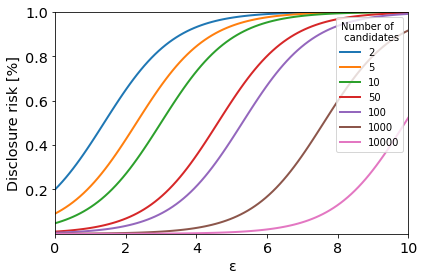

In [9]:
num_categories_list = [2, 5, 10, 50, 100, 1000, 10000]
fig = plt.figure()

for num_categories in num_categories_list:
    
    num_neighbors = 2 * num_categories + 1
    epss = np.linspace(0,10, 100)
    disclosure_risks = [disclosure_risk(num_neighbors, eps) for eps in epss]
    plt.plot(epss, disclosure_risks, linewidth=2, label='{}'.format(num_categories))

plt.plot
plt.margins(x=0)
plt.margins(y=0)
# plt.yscale('log')
plt.ylim(None, 1)
plt.xlabel('\u03B5', fontsize='x-large')
plt.ylabel('Disclosure risk [%]', fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(fontsize='xx-large')
plt.legend(title="Number of \n candidates", loc=1)
plt.savefig("Figures/zz_disclosure_risk_vs_eps.pdf", bbox_inches='tight')
plt.tight_layout()

!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX


# Expected Error Empirical Analysis

### Helper classes

In [319]:
class report_noisy_max:
    r"""
        Class that implements the report_noisy_max
        
    Parameters
    ----------
    epsilon : list
        Privacy parameter

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    candidate_qualities_dict : dict
        dictionary containing the candidates pegged to their quality values
    """  
    
    def __init__(self, epsilon, sensitivity, candidate_qualities_dict):
        
        __candidate_qualities_dict = candidate_qualities_dict
        
        self._epsilon = epsilon
        self._sensitivity = sensitivity
        self._candidate_qualities_dict = __candidate_qualities_dict
        self._laplace_mechanism = diffpriv_laplace.Laplace(epsilon=epsilon, sensitivity=sensitivity)
        
    def __repr__(self):
        
        return 'Noisy Max'

    def randomise(self):
        
        temp_dict = {}
        
        for key, value in self._candidate_qualities_dict.items():

            temp_dict[key] = self._laplace_mechanism.randomise(self._candidate_qualities_dict[key])

        return max(temp_dict, key=lambda k: temp_dict[k])
    

### Helper functions

In [218]:
def plotting_experiments(epsilons, expected_errors_dict, num_experiments, p_values):
    r"""
        Main function that executes an empirical evaluation of the expected error and plots the results.

    Parameters
    ----------
    epsilons : list
        Privacy parameters

    p_dictionary : dictionary of dictionaries
        Dictionary containing different sets off values for
        
    num_experiments: int
        Number of experiments to carry out per value of epsilon
        
    p_values: list of floats
        List of heads probabilities of randomized response
    """     
    x = epsilons
    fig, axs = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)
    #legend = [r'$M_{EM}$', r'$M_{PF}$', r'$M_{ERR}$']
    x_new = np.arange(1, 100, 0.01)/100
    for key, values in expected_errors_dict.items():
    
        f = interp1d(x, values, kind='cubic')
        axs.plot(x_new, f(x_new), label=key)
    
    axs.set_title('Expected error over {} experiments per \u03B5'.format(num_experiments))                   
    axs.set(xlabel='\u03B5', ylabel=r'$𝔼[Ɛ(\mathcal{M},\vec{q})]$')
    
    #plt.subplots_adjust(wspace=0.05)
    plt.legend(loc=(-0.1, -0.45), ncol=4)      
    plt.savefig("Figures/zz_Empirical_Expected_errors_experiments.pdf", bbox_inches='tight')
    plt.show()

In [219]:
def empirical_experiments_execution(num_experiments, mechanism, max_quality, candidate_qualities_dict):
    r"""
    Executes an empirical evaluation of the expected error for the different mechanisms

    Parameters
    ----------
    num_experiments: int
        Number of experiments to carry out per value of epsilon
        
    mechanism: object
        The object can be either from the class Exponential, PermuteAndFlip, EnhancedRandomizedResponse
    
    max_quality : float
        The highest quality value of the quality vector

    candidate_qualities_dict : dict
        dictionary containing the candidates pegged to their quality values
    """  
    errors = []
    
    for _ in range(num_experiments):
        
        output_category = mechanism.randomise()
        
        error = max_quality - candidate_qualities_dict[output_category]
        
        errors.append(error)
    
    expected_error = statistics.mean(errors)

    return expected_error

In [220]:
def setup_experiments(epsilons, sensitivity, p_values, candidate_qualities_dict, num_experiments):
    r"""
        Main function that executes an empirical evaluation of the expected error and plots the results.

    Parameters
    ----------
    epsilons : float
        Privacy parameters 

    sensitivity : float
        The sensitivity in utility values to a change in a datapoint in the underlying dataset.
        
    p_values: list of floats
        List of heads probabilities of randomized response
        
    candidate_qualities_dict : dict
        dictionary containing the candidates pegged to their quality values
        
    num_experiments: int
        Number of experiments to carry out per value of epsilon
    """ 
    expected_error_dictionary = {}
    
    quality_vector = list(candidate_qualities_dict.values())
    candidates = list(candidate_qualities_dict.keys())
    
    max_quality = max(quality_vector)
    
    # Initialize lists
    expected_error_dictionary[r'$\mathcal{M}_{EM}$'] = []
    expected_error_dictionary[r'$\mathcal{M}_{PF}$'] = []
    expected_error_dictionary[r'$\mathcal{M}_{NM}$'] = []
    for p in p_values:

        expected_error_dictionary[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)] = []
        
    for epsilon in epsilons: 

        # Inlcude any new mechanism for benchmarking
        # The onventional exponential mechanism
        exponential_mechanism = exponential.Exponential(epsilon=epsilon, sensitivity=sensitivity, monotonic=True, utility=quality_vector, candidates=candidates)

        expected_error = empirical_experiments_execution(num_experiments, exponential_mechanism, max_quality, candidate_qualities_dict)

        expected_error_dictionary[r'$\mathcal{M}_{EM}$'].append(expected_error)

        # Permute and flip
        permute_and_flip = exponential.PermuteAndFlip(epsilon=epsilon, sensitivity=sensitivity, monotonic=True, utility=quality_vector, candidates=candidates)
        
        expected_error = empirical_experiments_execution(num_experiments, permute_and_flip, max_quality, candidate_qualities_dict)

        expected_error_dictionary[r'$\mathcal{M}_{PF}$'].append(expected_error)
        
        # Report Noisy Max
        noisy_max = report_noisy_max(epsilon=epsilon, sensitivity=sensitivity, candidate_qualities_dict=candidate_qualities_dict)
        
        expected_error = empirical_experiments_execution(num_experiments, noisy_max, max_quality, candidate_qualities_dict)

        expected_error_dictionary[r'$\mathcal{M}_{NM}$'].append(expected_error)
        
        for p in p_values:
            
            # Enhanced randomised response
            enhanced_randomized_response = exponential.EnhancedRandomizedResponse(epsilon=epsilon, sensitivity=sensitivity, p=p, monotonic=True, candidate_quality_dict=candidate_qualities_dict)

            expected_error = empirical_experiments_execution(num_experiments, enhanced_randomized_response, max_quality, candidate_qualities_dict)

            expected_error_dictionary[r'$\mathcal{M}_{ERR}$' + '(p={})'.format(p)].append(expected_error)
            
    plotting_experiments(epsilons, expected_error_dictionary, num_experiments, p_values)                
        

### Independent variables

In [221]:
_num_experiments = 10000 # per epsilon
_epsilons = np.arange(1, 101, 1)/100
_p_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
_sensitivity = 1

## Experiment execution

Dependent variable:   
error = max_quality_socre - output_category_quality_score  
The expected value over all errors per epsilon

#### Best case, where the top catgory is more than a sensitivity away from the second highest

In [222]:
# It is an ordered mapping between categories and quality scores for lookup
_candidate_qualities_dict = {
    'A': 8,
    'B': 6,
    'C': 5,
    'D': 3,
    'E': 3,
    'F': 2
}

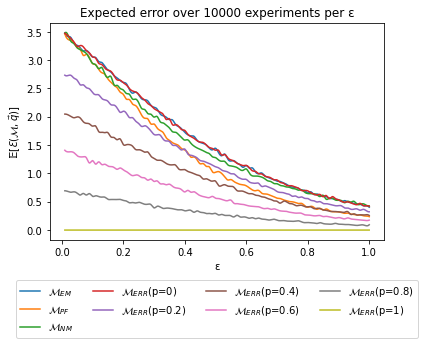

In [223]:
setup_experiments(_epsilons, _sensitivity, _p_values, _candidate_qualities_dict, _num_experiments)
!cp -R /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/Enhanced_Randomised_Response/Figures /Users/q493551/PhD/Papers/Enahnced_Randomized_Response_for_numeric_and_categorical_attributes/LATEX

#### Mid case, where half of the categories are in the same set

In [116]:
_candidate_qualities_dict = {
    'A': 7,
    'B': 6,
    'C': 5,
    'D': 3,
    'E': 3,
    'F': 2
}

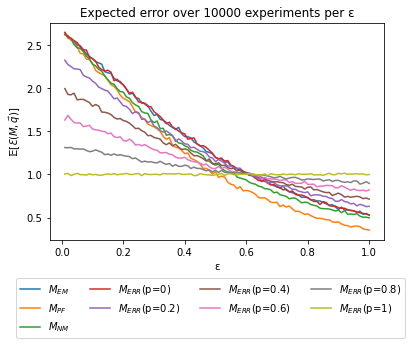

In [117]:
setup_experiments(_epsilons, _sensitivity, _p_values, _candidate_qualities_dict, _num_experiments)

#### Worst case, all categories are in the same set

In [160]:
_candidate_qualities_dict = {
    'A': 7,
    'B': 6,
    'C': 5,
    'D': 4,
    'E': 3,
    'F': 2
}

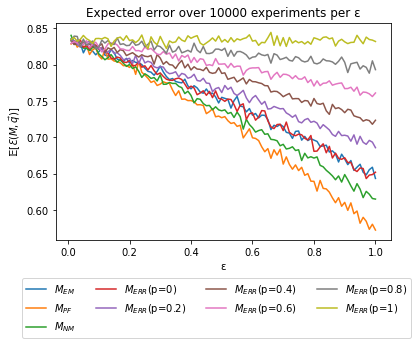

In [167]:
setup_experiments(_epsilons, _sensitivity, _p_values, _candidate_qualities_dict, _num_experiments)

In [168]:
_candidate_qualities_dict = {
    'A': 0,
    'B': -3,
    'C': -3,
    'D': -3,
    'E': -3,
    'F': -3
}

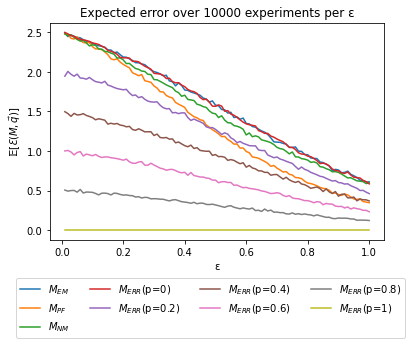

In [169]:
setup_experiments(_epsilons, _sensitivity, _p_values, _candidate_qualities_dict, _num_experiments)

In [170]:
_candidate_qualities_dict = {
    'A': 0,
    'B': -1,
    'C': -1,
    'D': -1,
    'E': -1,
    'F': -1
}

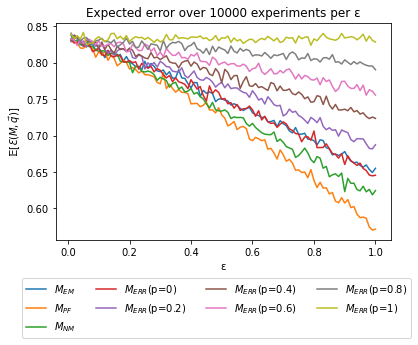

In [171]:
setup_experiments(_epsilons, _sensitivity, _p_values, _candidate_qualities_dict, _num_experiments)